# Libraries

In [1]:
import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt
from pathlib import Path
import sys

root = str(Path().resolve().parent)
if root not in sys.path:
    sys.path.append(root)
print(*sys.path, sep="\n")

# %matplotlib ipympl
%matplotlib inline

/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/ryanwtsai/repos/rfdsp_sim/python/venv/lib/python3.12/site-packages
/home/ryanwtsai/repos/rfdsp_sim/python


In [16]:
from importlib import reload
from rfdsppy import calc, ofdm, rf_analog as rfa, rf_tx_fw, \
    tonegen, digital_filter_design, rx_dfe_impcomp as rx_impcomp, \
        digital_hw_algo as dighw, plotting

reload(calc)
reload(ofdm)
reload(rfa)
reload(rf_tx_fw)
reload(tonegen)
reload(digital_filter_design)
reload(rx_impcomp)
reload(dighw)
reload(plotting)

<module 'rfdsppy.plotting' from '/home/ryanwtsai/repos/rfdsp_sim/python/rfdsppy/plotting.py'>

# Tx FD RSB

In [17]:
# Generate sample waveform

nsym = 14
modorder = 64
bw = 20
scs = 15
num_sc = 1200
start_sc = 600-round(num_sc/2)
en_tprecode = False
osr = 8
wola = 1
# sig_frac_bits = 15
# sig_power = -19
wg = ofdm.OFDMWavGen(bw, scs, modorder, start_sc, num_sc=num_sc, en_tprecode=en_tprecode, osr=osr, wola=wola)

x, x_standard = wg.generate(nsym)
cfg = wg.get_demod_params()
fs = cfg.get("fs")
wola_len = cfg.get("wola_len")
print(f"Fs (MHz) = {fs}")

Fs (MHz) = 245.76


(-368.64, 368.64)

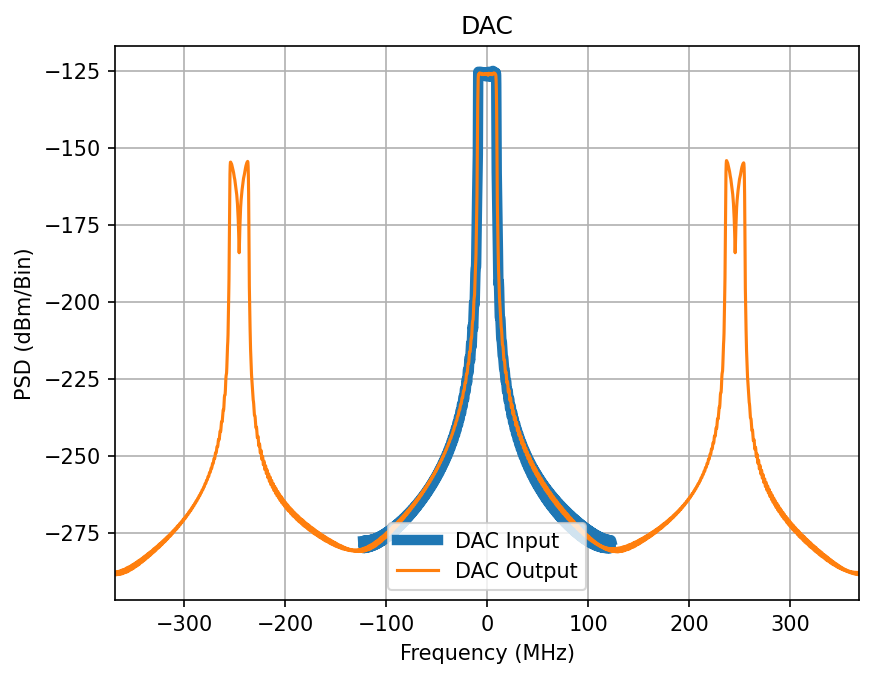

In [23]:
# Pass through DAC

R = 4
dac = rfa.DAC(R)
fs_dac = R*fs

x_dac = dac.transform(x)

py, fy = calc.psd(x_dac, fs_dac, fs_dac/2**12)
px, fx = calc.psd(x, fs, fs/2**12)

fig, axs = plt.subplots(dpi=150)
axs.plot(fx, 10*np.log10(px), label="DAC Input", linewidth=5)
axs.plot(fy, 10*np.log10(py), label="DAC Output")
axs.set_title(f"DAC")
axs.set_xlabel("Frequency (MHz)")
axs.set_ylabel("PSD (dBm/Bin)")
axs.grid()
axs.legend(loc="lower center")
axs.set_xlim(left=-fs*1.5, right=fs*1.5)

digital_filter_design.iir_bbf()
Filter order = 3
Maximum passband loss (dB) = 5.48
Minimum stopband attenuation (dB) = 65.4





(-368.64, 368.64)

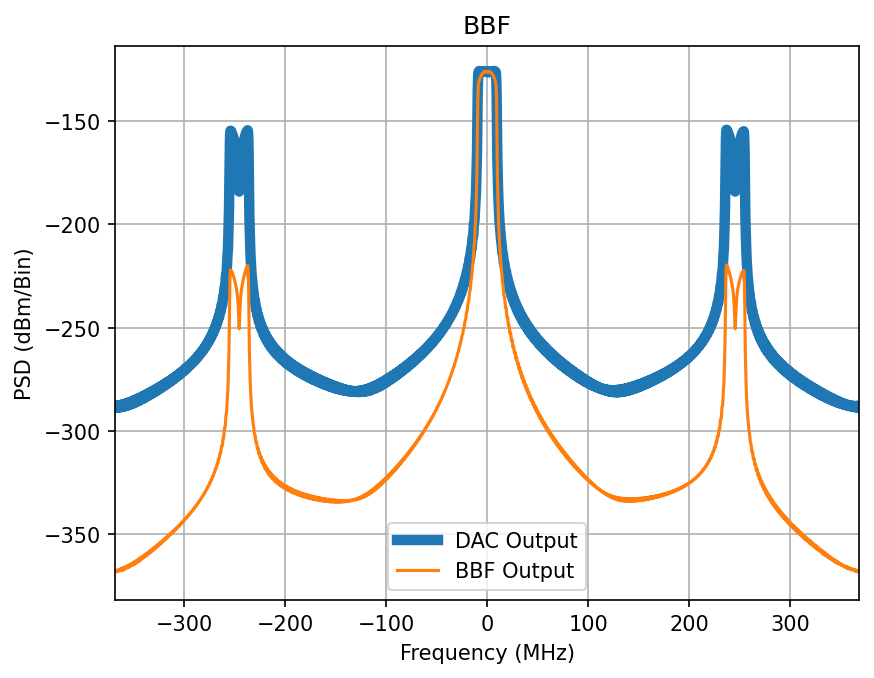

In [33]:
# Pass through analog BBF

obw = num_sc*scs/1000
wp = obw/fs_dac
ws = (fs-obw/2)/(fs_dac/2)
gpass = 6
gstop = 50

b, a = digital_filter_design.iir_bbf(wp, ws, gpass, gstop, en_plot=False)

x_bbf = signal.lfilter(b, a, x_dac)

py, fy = calc.psd(x_bbf, fs_dac, fs_dac/2**12)
px, fx = calc.psd(x_dac, fs_dac, fs_dac/2**12)

fig, axs = plt.subplots(dpi=150)
axs.plot(fx, 10*np.log10(px), label="DAC Output", linewidth=5)
axs.plot(fy, 10*np.log10(py), label="BBF Output")
axs.set_title(f"BBF")
axs.set_xlabel("Frequency (MHz)")
axs.set_ylabel("PSD (dBm/Bin)")
axs.grid()
axs.legend(loc="lower center")
axs.set_xlim(left=-fs*1.5, right=fs*1.5)